In [1]:
from __future__ import (absolute_import, print_function, unicode_literals,
                        division)

import logging
logging.basicConfig(level=logging.DEBUG)

import joblib
import dropbot as db
import dropbot.chip
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker
import numpy as np
import pandas as pd
import si_prefix as si

# %matplotlib inline

F_formatter = mpl.ticker.FuncFormatter(lambda x, *args: si.si_format(x) + 'F')

# Load Sci-Bots device file and extract neighbouring channels info.
svg_path = dropbot.DATA_DIR.joinpath('SCI-BOTS 90-pin array', 'device.svg')

# Used cached neighbours result (if available).  Otherwise, cache neighbours.
memcache = joblib.memory.Memory('.')
get_channel_neighbours = memcache.cache(db.chip.get_channel_neighbours)
neighbours = get_channel_neighbours(svg_path)

# Open DropBot connection

In [2]:
import base_node_rpc as bnr
import base_node_rpc.proxy

try:
    proxy.terminate()
except:
    pass
proxy = db.SerialProxy(ignore=[bnr.proxy.DeviceVersionMismatch])
proxy.neighbours = neighbours

proxy.enable_events()

proxy.update_state(hv_output_enabled=True, hv_output_selected=True,
                   voltage=100, frequency=10e3)

# Disable channels in contact with copper tape.
disabled_channels_mask_i = proxy.disabled_channels_mask
disabled_channels_mask_i[[89, 30]] = 1
# Disable channels with no neighbours defined.
neighbour_counts = neighbours.groupby(level='channel').count()
disabled_channels_mask_i[neighbour_counts.loc[neighbour_counts < 1].index] = 1
proxy.disabled_channels_mask = disabled_channels_mask_i

DEBUG:trollius:Using selector: SelectSelector
DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM15 (baudrate=115200)
DEBUG:serial_device.threaded:Open `COM15` and monitor connection status
DEBUG:serial_device.threaded:connection_made: `COM15` `<ReaderThread(Thread-13, started daemon 5116)>`
DEBUG:base_node_rpc.proxy:Wait for connection to port COM15
INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM15


<IPython.core.display.Javascript object>


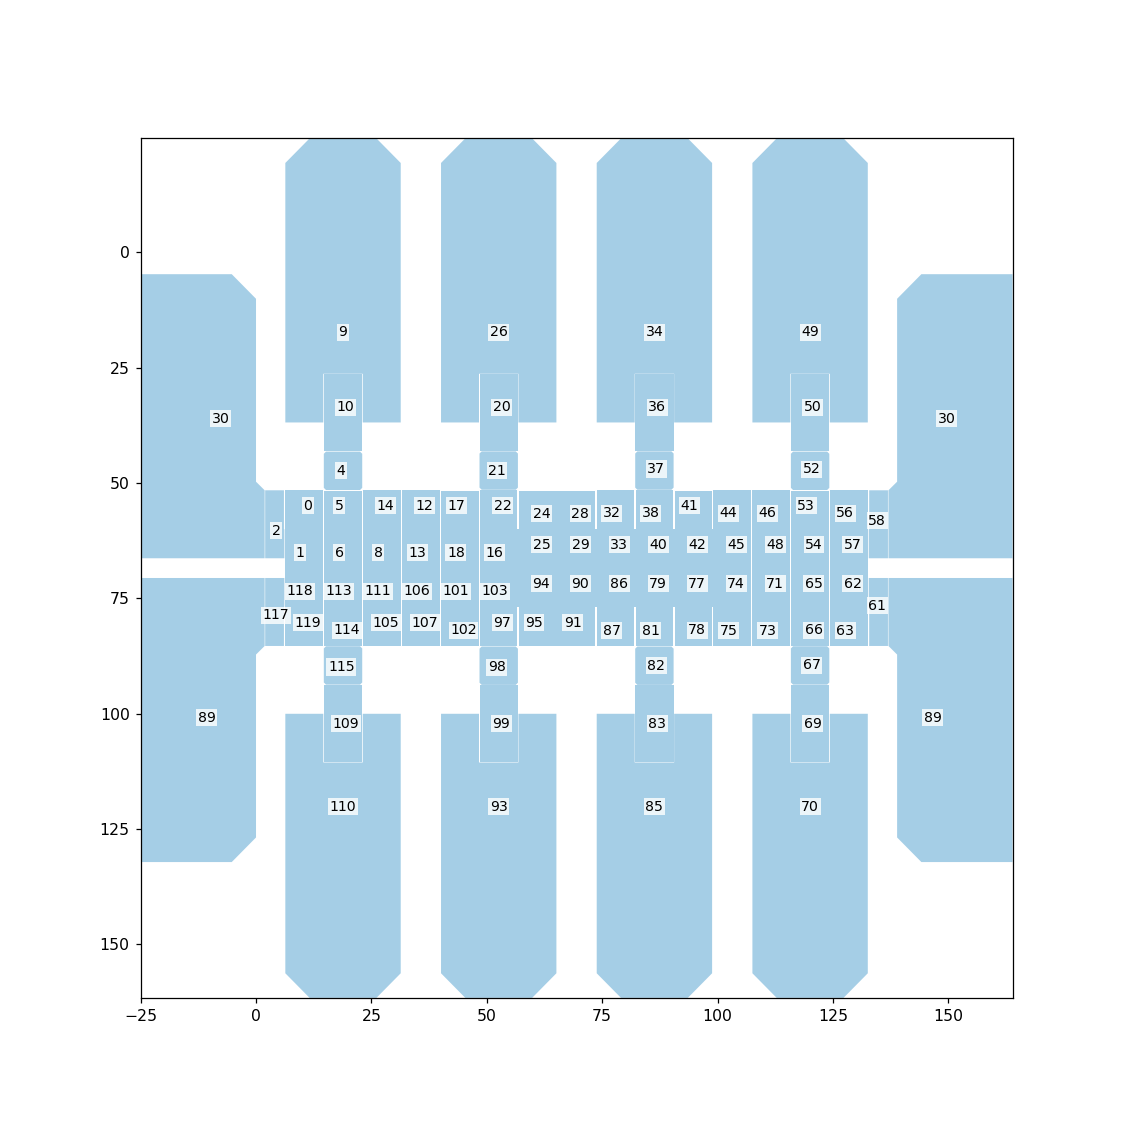

8

In [3]:
%matplotlib notebook
import blinker
import dropbot as db
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.collections
import svg_model
import threading
import traceback
import si_prefix as si
import time


display_channels = True
svg_path = db.DATA_DIR.joinpath('SCI-BOTS 90-pin array', 'device.svg')
df_shapes = svg_model.svg_shapes_to_df(svg_path)

electrode_channels = df_shapes.drop_duplicates(['id', 'data-channels']).set_index('id')['data-channels'].map(int)
channel_electrodes = pd.Series(electrode_channels.index, index=electrode_channels.values)
# Do not include edge electrodes in capacitance measurements.
# XXX Should probaaly add the edge electrodes to disabled channel mask.
channels = (electrode_channels.drop(['electrode%03d' % i
                                     for i in [57, 58, 73, 74]])
            .drop_duplicates().sort_values())

patches = {id_: mpl.patches.Polygon(df_shape_i[['x', 'y']].values,
                                    closed=False, label=id_)
           for id_, df_shape_i in df_shapes.groupby('id')}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect(True)

electrode_capacitances = pd.Series([10e-12] * len(patches.keys()),
                                   index=patches.keys())

my_cmap = cm.get_cmap('Blues') # or any other one
norm_capacitance = mpl.colors.Normalize(0, 20e-12)  #electrode_capacitances.max())

state_of_channels = proxy.state_of_channels


def electrode_state(electrode_id):
    if electrode_id in electrode_channels:
        channel = electrode_channels.loc[electrode_id]
        electrode_state_i = state_of_channels[channel]
        if isinstance(channel, pd.Series):
            electrode_state_i = electrode_state_i.any()
        return electrode_state_i
    
    
def render_electrode(electrode_id, capacitance=None):
    patch_i = patches[electrode_id]
    if capacitance is not None:
        patch_i.set_facecolor(my_cmap(norm_capacitance(capacitance_i)))
    electrode_state_ = electrode_state(electrode_id)
    patch_i.set_alpha(1. if electrode_state_ else .6)
    patch_i.set_edgecolor('black' if electrode_state_ else None)
        

for id_i, patch_i in patches.items():
    electrode_id = patch_i.get_label()
    electrode_state_i = electrode_state(id_i)
    capacitance_i = (0 if electrode_state_i is None
                     else electrode_capacitances.loc[electrode_id])
    render_electrode(electrode_id, capacitance_i)
    ax.add_patch(patch_i)
    patch_i.set_picker(True)

# Compute center `(x, y)` for each electrode.
electrode_centers = df_shapes.groupby('id')[['x', 'y']].mean()
# Index by **channel number** instead of **electrode id**.
electrode_centers.index = electrode_channels.reindex(electrode_centers
                                                     .index)
    
if display_channels:
    for channel_i, center_i in electrode_centers.iterrows():
        ax.text(center_i.x, center_i.y, str(channel_i),
                horizontalalignment='center', verticalalignment='center',
                color='black', fontsize=9, bbox={'facecolor': 'white',
                                                 'alpha': 0.8, 'pad': 1,
                                                 'edgecolor': 'none'})

ax.set_xlim(df_shapes.x.min(), df_shapes.x.max())
ax.set_ylim(df_shapes.y.max(), df_shapes.y.min())

# connection_id = fig.canvas.mpl_connect('button_press_event', onclick)
picks = []


def on_channels_updated(event):
    try:
        actuated_channels = set(event['actuated'])
        state_of_channels[:] = 0
        state_of_channels[list(actuated_channels)] = 1

        for channel_i, electrode_id_i in channel_electrodes.items():
            render_electrode(electrode_id_i)
    except Exception as exception:
        text_capacitance.set_text(str(actuated_channels) + '\n' + traceback.format_exc(exception))
        

def on_capacitance_updated(event):
    text_capacitance.set_text('capacitance: {}F'.format(si.si_format(event['new_value'])))
    fig.canvas.draw_idle()
    
    
def on_channel_capacitances(capacitances):
    electrode_capacitances[:] = capacitances.reindex(electrode_channels)
    electrode_capacitances.index = electrode_channels.index
    
    try:
        for electrode_id_i, patch_i in patches.items():
            capacitance_i = electrode_capacitances.loc[electrode_id_i]
#             norm_capacitance.vmax = electrode_capacitances.max()
            color_i = my_cmap(norm_capacitance(capacitance_i))
            patch_i.set_facecolor(color_i)
        fig.canvas.draw_idle()
    except Exception as exception:
        text_capacitance.set_text(traceback.format_exc(exception))


def on_drops_detected(event):
    drops_events.append(event)
    if not event['drops']['channels']:
        return
    drops_channels = np.concatenate(event['drops']['channels'])
    drops_capacitances = np.concatenate(event['drops']['capacitances'])
    
    channel_capacitances = pd.Series(drops_capacitances, index=drops_channels)

    electrode_capacitances[:] = channel_capacitances.reindex(electrode_channels)
    electrode_capacitances.index = electrode_channels.index
    
    try:
        for electrode_id_i, patch_i in patches.items():
            capacitance_i = electrode_capacitances.loc[electrode_id_i]
            color_i = my_cmap(norm_capacitance(capacitance_i))
            patch_i.set_facecolor(color_i)
        fig.canvas.draw_idle()
    except Exception as exception:
        text_capacitance.set_text(traceback.format_exc(exception))


signals = blinker.Namespace()
for signal in ('onpick', 'channel-capacitances'):
    for key, receiver in signals.signal(signal).receivers.items():
        signal.disconnect(receiver)
signals.signal('onpick').connect(picks.append, weak=False)
signals.signal('channel-capacitances').connect(on_channel_capacitances, weak=False)

drops_events = []
proxy.signals.clear()
proxy.signals.signal('drops-detected').connect(on_drops_detected, weak=False)
channels_signal = proxy.signals.signal('channels-updated')
# Attach channels update listener
channels_signal.connect(on_channels_updated, weak=False)

capacitance_signal = proxy.signals.signal('capacitance-updated')
# Attach capacitance update listener
capacitance_signal.connect(on_capacitance_updated, weak=False)

def on_pick(event):
    if event.mouseevent.button != 1:
        return
    signals.signal('onpick').send(event)
    electrode_id = event.artist.get_label()
    
    try:
        if electrode_id in electrode_channels:
            channel_i = electrode_channels[electrode_id]
            electrode_state_i = not state_of_channels[channel_i].any()
            state_of_channels[channel_i] = electrode_state_i 
        else:
            channel_i = None
            electrode_state_i = 0
    except Exception as exception:
        text.set_text('onpick: {}'.format(traceback.format_exc(exception)))
        text.set_text('onpick: {}'.format((event.artist.get_label(), channel_i)))
    proxy.state_of_channels = state_of_channels
    

text = ax.text(0,0, "", va="bottom", ha="left")
text_capacitance = ax.text(0, 0, "", va="bottom", ha="left", transform=ax.transAxes)


fig.canvas.mpl_connect('pick_event', on_pick)

In [4]:
proxy.drops

[array([ 94,  97, 103], dtype=uint8)]

In [5]:
proxy.update_state(drops_update_interval_ms=int(0))

1

-----------------------------------------------------------------------------------------------

# Close DropBot connection

In [6]:
proxy.terminate()

DEBUG:serial_device.threaded:Connection to port `COM15` closed
DEBUG:base_node_rpc.proxy:Connection lost `COM15`


-----------------------------------------------------------------------------------------------